In [24]:
import networkx as nx
from new_covers import *
#TODO: add reference to paper

# Procedure
In this notebook we generate a dataset of non isomorphic covering spaces of degree $d$ of a base graph $G$ satisfying some assumptions. By the Theorem of the paper, the resulting graphs are pairwise non-isomorphic.


Given a graph $G$ satisfying some conditions (connected, but this will be relaxed in the future), all neighbouring nodes are distinguishable by colour refinement, and it has Euler characteristic <0), and a parameter $k$, we generate all coverings of $G$ of degree $k$. 

We will then train GNNs to try to distinguish them, reproducing the results of the paper.

In [2]:
# Start by fixing a base graph, connected with two loops, and each nodes are distinguishable by WL colouring

edge_index = [[0, 1], [1, 0],
              [1, 2], [2, 1],
              [2, 3], [3, 2],
              [2, 4], [4, 2],
              [3, 4], [4, 3],
              [4, 5], [5, 4],
              [5, 6], [6, 5],
              [5, 8], [8, 5],
              [6, 7], [7, 6],
              [6, 8], [8, 6]]

# Distinguished edges (one per cycle) to make sampling more efficient
cycle_edge = [[2, 4], [5, 6]]

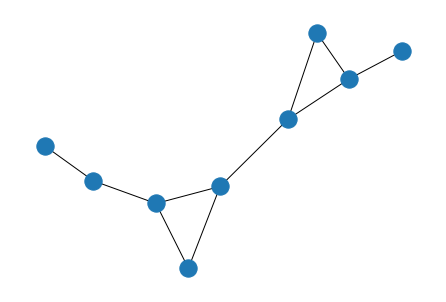

In [3]:
G = nx.Graph(edge_index)
nx.draw(G)

In [4]:
# Generate all pairwise non-isomorphic degree 3 covers 
graphCovers = gen_graphCovers(edge_index, degree=4, cycle_edge=cycle_edge, nb_covers=5)

Total number of covers to check:  576
We found  5  covers ! Only in  41  tries!


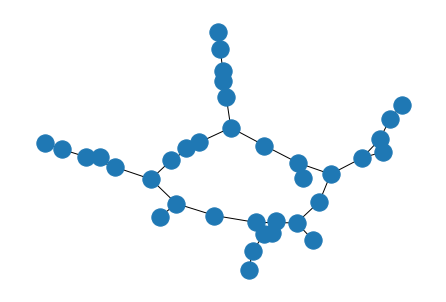

In [21]:
# Here is a plot from networkx. It is random and rather confusing, check out our custom visualization plot below!
nx.draw(graphCovers[0].nxGraph)

## Custom cover visualisation

In [22]:
# We set good coordinates for nodes in base graph (this is optional)
# If these are not available, set coord=None
coord = {0: [-4., 0.],
        1: [-3., 0.],
        2: [-2., 0.],
        4: [-1., 0.],
        5: [0., 0.],
        6: [1., 0.],
        7: [2., 0.],
        3: [-1.5, np.sqrt(0.75)],
        8: [0.5, np.sqrt(0.75)]}

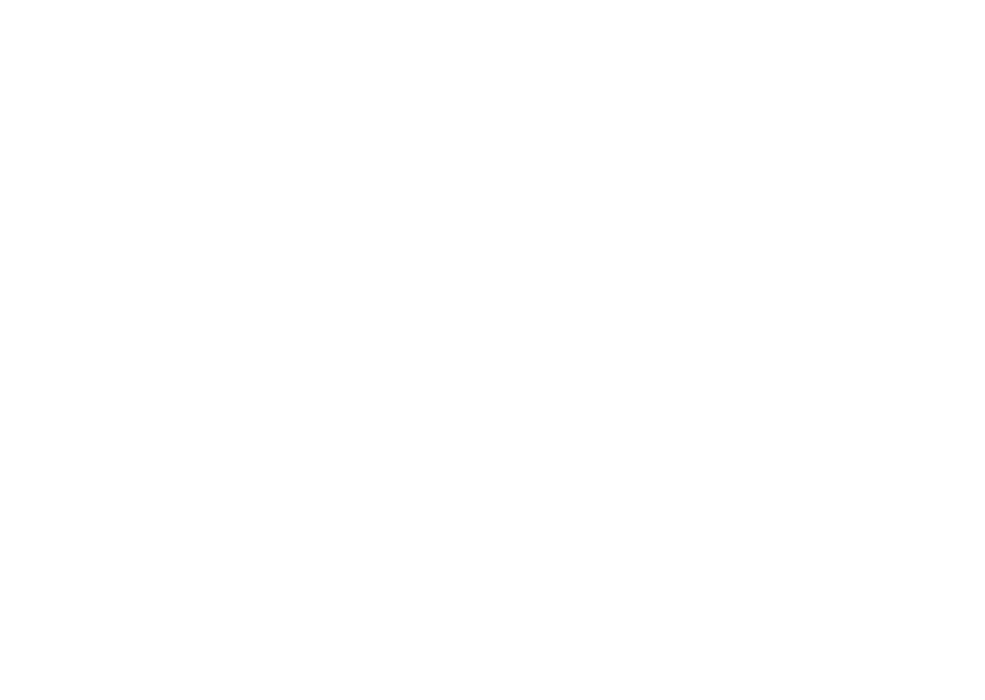

In [23]:
k = 3 # pick the index in graphCovers generated above
graphCovers[k].plot(coord)

## Make a dataset

In [12]:
import torch
from torch_geometric.data import Data

In [13]:
# First get them as a list of torch_geometric Data object, with the WL colouring
data_list = []
for cover in graphCovers:
    edge_index = torch.tensor(cover.edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(cover.get_colour_signal())
    data_list += [Data(x=x, edge_index=edge_index)]

In [14]:
data_list[0]

Data(x=[36, 9], edge_index=[2, 80])

In [15]:
#make three classes:
for i, data in enumerate(data_list):
    if i%3==0:
        data.y = torch.tensor([0], dtype=torch.long)
    if i%3==1:
        data.y = torch.tensor([1], dtype=torch.long)
    if i%3==2:
        data.y = torch.tensor([2], dtype=torch.long)

In [16]:
# lets try out our method only on 3 non-isomorphic graphs (that are deg 5)...
small_list = [data_list[0], data_list[1], data_list[2]]
small_list[0].y, small_list[1].y, small_list[2].y

(tensor([0]), tensor([1]), tensor([2]))

# GNNs experiments

In [17]:
# now lets get learning!!!
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GINConv, GATConv, ChebConv
from torch_geometric.nn import Linear as Linear_pyg

class SIMPLE(torch.nn.Module):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__()
        self.conv1 = None
        self.conv2 = None
        self.fc = torch.nn.Linear(2*hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        emb1 = x.mean(dim=0, keepdim=True)
        emb2 = torch.max(x, dim=0, keepdim=True).values
        emb = torch.cat((emb1, emb2), dim=1)
        x = self.fc(emb)

        return F.softmax(x, dim=1), emb

class GCN(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
    
class SAGE(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)

class GAT(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = GATConv(in_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)

class GIN(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = GINConv(nn=Linear_pyg(in_dim, hidden_dim))
        self.conv2 = GINConv(nn=Linear_pyg(hidden_dim, hidden_dim))
        
class CHEB(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = ChebConv(in_dim, hidden_dim, K=1)
        self.conv2 = ChebConv(hidden_dim, hidden_dim, K=1)

In [18]:
def train_model(model, data_list):
    cross_entropy = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(400):
        for data in data_list:
            optimizer.zero_grad()
            out, emb = model(data)
            loss = cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()
        if epoch%150==0:
            print("loss: ", loss)
            print(out.sum(), emb.sum())


def eval_model(model, data_list):
    model.eval()
    preds = [model(data)[0].argmax(dim=1) for data in data_list]
    correct = sum([1 if preds[i]==data_list[i].y else 0 for i in range(len(data_list))])
    acc = int(correct) / len(data_list)
    print(f'Train accuracy: {acc:.4f}')

    bool = torch.equal(model(data_list[0])[1].repeat((len(data_list), 1)), torch.stack([model(data_list[i])[1][0] for i in range(len(data_list))] ))
    print("All embeddings are all equal: ", bool)
    if bool:
        print("All predictions are: ", model(data_list[0])[0].argmax(dim=1))


In [19]:
def whole_analysis(data_list, in_dim=16, hidden_dim=16, num_classes=97):
    print("GCN: ")
    print("")
    model = GCN(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)

    print("")
    print("GAT")
    print("")
    model = GAT(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)

    print("")
    print("GIN: ")
    print("")
    model = GIN(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)

    print("")
    print("SAGE: ")
    print("")
    model = SAGE(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)
    
    print("")
    print("Cheb: ")
    print("")
    model = CHEB(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)


## constant signal

In [20]:
for data in small_list:
    data.x = torch.ones((data.x.shape[0], 1))
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, 1, 100, num_classes=3)

signal dimension:  torch.Size([36, 1])
GCN: 

loss:  tensor(1.2015, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(10.0006, grad_fn=<SumBackward0>)
loss:  tensor(1.0956, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0315, grad_fn=<SumBackward0>)
loss:  tensor(1.0977, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0002, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  True
All predictions are:  tensor([2])

GAT

loss:  tensor(1.1961, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(11.2369, grad_fn=<SumBackward0>)
loss:  tensor(1.0997, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0006, grad_fn=<SumBackward0>)
loss:  tensor(1.0991, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(4.4143e-06, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  True
All predictions are:  tensor([0])

GIN: 

loss: 

## Degree signal

In [17]:
from torch_geometric.utils import degree
for data in data_list:
    data.x = degree(data.edge_index[0]).unsqueeze(1)
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=1, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.2538, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(20.8969, grad_fn=<SumBackward0>)
loss:  tensor(1.0994, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0529, grad_fn=<SumBackward0>)
loss:  tensor(1.0990, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0135, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  True
All predictions are:  tensor([1])

GAT

loss:  tensor(1.2776, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(21.9648, grad_fn=<SumBackward0>)
loss:  tensor(1.0988, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(0.0516, grad_fn=<SumBackward0>)
loss:  tensor(1.0988, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0287, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  True
All predictions are:  tensor([1])

GIN: 

loss:  ten

## Random normal signal

In [12]:
for data in small_list:
    data.x = torch.normal(mean = 0, std = torch.ones(45, 1))
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=1, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.2288, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(13.3182, grad_fn=<SumBackward0>)
loss:  tensor(0.5529, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(223.7640, grad_fn=<SumBackward0>)
loss:  tensor(0.5525, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(197.5469, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GAT

loss:  tensor(1.2368, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(13.2937, grad_fn=<SumBackward0>)
loss:  tensor(0.5522, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(186.8474, grad_fn=<SumBackward0>)
loss:  tensor(0.5520, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(174.7480, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GIN: 

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad

## Random uniform

In [ ]:
for data in small_list:
    data.x = torch.rand(size=data.x.shape)
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=1, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.1609, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(5.6607, grad_fn=<SumBackward0>)
loss:  tensor(0.8342, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(126.7008, grad_fn=<SumBackward0>)
loss:  tensor(0.8101, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(260.4312, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GAT

loss:  tensor(1.1509, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(6.6010, grad_fn=<SumBackward0>)
loss:  tensor(0.6523, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(45.0819, grad_fn=<SumBackward0>)
loss:  tensor(0.5586, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(67.1575, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GIN: 

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<Sum

## Unique Identifiers:
each of the node of a graph gets a unique identifier.

In [ ]:
for data in small_list:
    temp = torch.zeros((45, 45))
    for i in range(45): # one per node
        temp[i, i] = 1
    data.x = temp
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=45, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(1807.9285, grad_fn=<SumBackward0>)
loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(325.2245, grad_fn=<SumBackward0>)
loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(165.9739, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  False

GAT

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(1825.8007, grad_fn=<SumBackward0>)
loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(476.0897, grad_fn=<SumBackward0>)
loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(124.4833, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  False

GIN: 

loss:  tensor(0.5514, grad_fn=<NllLossBackward>)
tensor(1., 

## y as the signal

In [26]:
from torch_geometric.utils import degree
for data in small_list:
    data.x = data.y.float().repeat((45, 1))
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=1, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.1574, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(16.2284, grad_fn=<SumBackward0>)
loss:  tensor(0.5520, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(79.4581, grad_fn=<SumBackward0>)
loss:  tensor(0.5519, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(77.2605, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GAT

loss:  tensor(1.1405, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(14.7141, grad_fn=<SumBackward0>)
loss:  tensor(0.5520, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(78.1413, grad_fn=<SumBackward0>)
loss:  tensor(0.5519, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(75.7573, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GIN: 

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad